In [277]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import random
import pandas as pd
import seaborn as sb
import copy
import scipy

At 0K we have a real (choose positive) 1D function in a spatially varying 1D potential of the form

H = alpha(z) (Psi)^2 + c(z) (d \Psi) ^2 + u(z)/2 \Psi^4

With spatially varying coefficients u(z), c(z) ~ circumference = 2 pi r(a) (1+ a sin(kz))

alpha(z) = (alpha_0 + c |i n A_th|^2) \* circumference
     = (alpha_0 + c n^2 R'(z)/ R(z) ) \* 2 pi r(a) (1 + a sin kz)

   = alpha_0 2 pi r(a)(1+a sin kz ) + c_0 n^2 2 pi r(a) (1+a sin kz) ( k r a cos(kz) )^2/ (1+ a^2 k^2 r(a)^2 cos^2 kz)

With radius rescaled r(a) = 1 / sqrt(q - a^2/2)

Quantities radius_rescaled r(a) = r_0 / sqrt(1+a^2/2)

A_theta A_th = k r a cos(kz) / sqrt_g_zz

g_z= (1+a^2 k^2 a(r)^2 cos^2 kz) and sqrt_g_z

and sqrt_g_th = r(a) (1+a sin kz)

can be retrieved from system_cylinder

In [148]:
import surfaces_and_fields.system_cylinder as system_cylinder


In [149]:
#the cylinder object holds k, r0
def alpha_z_index_raise(alpha0, c0, n, a, z, cylinder):
    return (alpha0 + c0 * n**2 * cylinder.A_theta(amplitude=a,z=z)**2 #A th and grad parts incl a factor of eta_thth, 
           /cylinder.g_theta(amplitude=a, z=z)
           )#*2*math.pi*cylinder.sqrt_g_theta(amplitude=1, z=z)        #index raise in cylidrical coordinates
                                                                      #the factor is 1/gthth
#the cylinder object holds k, r0
def Ath2(alpha0, c0, n, a, z, cylinder):
    return (cylinder.A_theta(amplitude=a,z=z)**2 #A th and grad parts incl a factor of eta_thth, 
           /cylinder.g_theta(amplitude=a, z=z)
           )#*2*math.pi*cylinder.sqrt_g_theta(amplitude=1, z=z)        #index raise in cylidrical coordinates
                                                                      #the factor is 1/gthth

def alpha_z(alpha0, c0, n, a, z, cylinder):
    return (alpha0 + c0 * n**2 * cylinder.A_theta(amplitude=a,z=z)**2 
           )#*2*math.pi*cylinder.sqrt_g_theta(amplitude=1, z=z)        #
           #this factor of circumfrence always cancels locally

In [150]:
def c_z(c0, a, z, cylinder):
    return c0/ cylinder.g_z(amplitude=a, z=z) #two factors of 1/sqrt_g_z in the gradient.  A_th^2 has them too.  
                                              # it's for changing distance in gradient = diff / diff x . 
                                              # in general
                                              # since gradient energy is also weighted by line segment length 1x (in 1D),
                                              # this combines to 1/sqrt_g_z
                                              # but here we cancelled that factor of sqrt_g on u,alpha, and c
                                              # along with circumference

def u_z(u0, a, z, cylinder):
    return u0#*2*math.pi*cylinder.sqrt_g_theta(amplitude=1, z=z)

next we need to find, for each k and a, the solution Psi that is minimized in this potential

Equation of motion / variational derivative is

0 = d H / dPsi - d_z (d H / d dPsi )

= 2 alpha(z) Psi + 2 u(z) Psi^3 - 2 dz (c(z) dPsi)

wave equation

alpha(z) Psi + u(z) Psi^3 = c(z) dzz Psi

In [428]:
def get_local_energy(alpha_zs, u0, z_index, value, z_space):
    return (alpha_zs[z_index]*value**2 + u0/2 * value**4)*z_space*2*math.pi

In [429]:
def get_grad_energy(c_zs, z_index, z_space, value1, value2):
    gradient = (value1-value2)/(z_space)
    return (c_zs[z_index]*gradient**2)*z_space*2*math.pi

In [415]:
def metropolis_decision(energy_diff,T):
    if energy_diff >=0:
        return True
    elif T==0:
        return (energy_diff>=0)
    else:
        probability=math.exp(energy_diff/T)
        rand = random.uniform(0,1)
        if rand <= probability:
            #print(energy_diff, probability)
            return True
        else:
            return False

In [416]:
def metropolis_minimize(zs, alpha_zs, c_zs, n,u0, initial, n_steps, T=0.01):
    counter=0
    l=len(zs)
    z_len = zs[1]-zs[0]
    arr=initial
    energy=[get_local_energy(alpha_zs, u0, n, value, z_len) for n,value in enumerate(initial)]
    #print(zs, arr)
    grad_energy=[get_grad_energy(c_zs,n, z_len, arr[n-1], arr[n]) for n, value in enumerate(initial[:-1])]
    #print(l, len(arr))
    grad_energy.append(get_grad_energy(c_zs,n, z_len, arr[-1], arr[0]))
    for i in range(n_steps):
        for j in range(l):
            loc = random.choice(range(l))
            new_value = random.gauss(arr[loc], step)
            while new_value<0:
                new_value = random.gauss(arr[loc], step)
                adapt_step(False, counter)
                #print(step, new_value)
            new_local_energy = get_local_energy(alpha_zs, u0, loc,new_value, z_len)
            new_left_derivative_energy = get_grad_energy(c_zs,loc, z_len, arr[loc-1],new_value)
            try:
                new_right_derivative_energy = get_grad_energy(c_zs,loc, z_len, new_value, arr[loc+1])
            except IndexError:
                new_right_derivative_energy = get_grad_energy(c_zs,loc, z_len, new_value, arr[loc+1-l])
            try:
                energy_diff = (energy[loc]+grad_energy[loc]+grad_energy[loc+1])-(new_local_energy+new_left_derivative_energy+new_right_derivative_energy)
            except IndexError:
                energy_diff = (energy[loc]+grad_energy[loc]+grad_energy[loc+1-l])-(new_local_energy+new_left_derivative_energy+new_right_derivative_energy)
            accept=metropolis_decision(energy_diff,T)
            #print(energy_diff, accept)
            if accept:
                energy[loc]= new_local_energy
                grad_energy[loc] = new_left_derivative_energy
                try:
                    grad_energy[loc+1] = new_right_derivative_energy
                except IndexError:
                    grad_energy[loc+1-l] = new_right_derivative_energy
                arr[loc]=new_value
            counter+=1
            adapt_step(accept, counter)

        #print(sum(energy), sum(grad_energy), sum(energy)+ sum(grad_energy), step)
    return (arr, energy, grad_energy, step)

In [417]:
m=1
target=.2
alpha = -1 * scipy.stats.norm.ppf(target/ 2)
ratio=  (1 - (1 / m)) * math.sqrt(2 * math.pi) * math.exp(alpha ** 2 / 2) / 2 * alpha + 1 / (m * target * (1 - target))
def adapt_step(accept, counter):
    global step
    step_number_factor = max(counter/m, 150)
    steplength_c =step * ratio
    if accept:
        step += steplength_c * (1 - target) / step_number_factor
    else:
        step -= steplength_c * target/ step_number_factor
    assert (step) > 0

In [464]:
k=.9
alpha0=-4
c0=6.5
n=6
u0=1
a=.5
z_space=.1
cylinder = system_cylinder.Cylinder(wavenumber=k, radius=1, kappa=0)
zs = np.arange(0, 2*math.pi/k, z_space)
alpha_zs= [alpha_z_index_raise(alpha0, c0, n, a, z, cylinder) for z in zs]
c_zs= [c_z(c0, a, z, cylinder) for z in zs]
u_zs= [u_z(u0, a, z, cylinder) for z in zs]

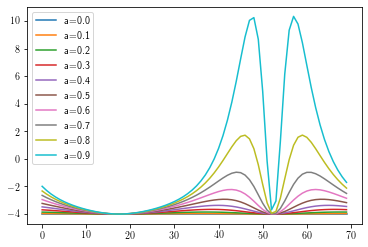

In [419]:
for a in a_s:
    cylinder = system_cylinder.Cylinder(wavenumber=k, radius=1, kappa=0)
    zs = np.arange(0, 2*math.pi/k, z_space)
    alpha_zs= [alpha_z_index_raise(alpha0, c0, n, a, z, cylinder) for z in zs]
    plt.plot(alpha_zs, label="a="+str(round(a,3)))
plt.legend()

In [420]:
#arr=[random.uniform(0,1) for z in zs]

In [431]:
def field_energy(a, k, alpha0, c0, n, u0, z_space=z_space, radius=1, n_steps=5000,  initial=None, T=.01):
    cylinder = system_cylinder.Cylinder(wavenumber=k, radius=radius, kappa=0)
    zs = np.arange(0, 2*math.pi/k, z_space)
    if initial is None:
        initial=[abs(alpha0)*.5 for z in zs]
    alpha_zs= [alpha_z_index_raise(alpha0, c0, n, a, z, cylinder) for z in zs]
    c_zs= [c_z( c0, a, z, cylinder) for z in zs]
    alpha_curv_energys_zs = [alpha-alpha0 for alpha in alpha_zs]
    arr, energy, grad_energy, curv_energy = metropolis_minimize(zs, alpha_zs, c_zs, n,u0, 
                                                     initial,  n_steps, T=T)
    energy=sum(energy)+sum(grad_energy)
    curv_energy=sum([alpha_Ai_part*arr[n]**2 for n, alpha_Ai_part in enumerate(alpha_curv_energys_zs)] )
    print(step)
    return energy, curv_energy, arr

0.0015243434965488602
0.0 6.5 -351.8545076065653 0.0
0.0015051316898870393
0.1 6.5 -206.62249489551118 196.69987578187582
0.0009736073541220638
0.2 6.5 -6.5072410589719825 107.43489312142422
0.0015427139203544643
0.30000000000000004 6.5 0.0036940242231046395 0.0019114902816249758
0.0015494639701848618
0.4 6.5 0.005622902677844034 0.0035229371952200496
0.0015445528066012396
0.5 6.5 0.004663868712565822 0.002459314403260569
0.0015356481842172542
0.6000000000000001 6.5 0.003963348483992542 0.0018588464104093373
0.0015040301019876381
0.7000000000000001 6.5 0.004070744434876554 0.002780932672596254
0.0014532906745460873
0.8 6.5 0.0048194545925123525 0.003089134039495784
0.0013597915439739635
0.9 6.5 0.003979680510690954 0.0031958590333753295


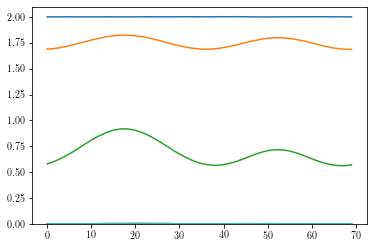

In [445]:
energys={}
curv_energys={}
old_arrs=copy.deepcopy(arrs)
arrs={}
for a in np.arange(0, 1, .1):
    if a in old_arrs:
        arr=copy.deepcopy(old_arrs[a])
    else:
        print(a,"not found")
    e, c_e, arr = field_energy(a=a,k=k,alpha0=alpha0,c0=c0,n=n,u0=u0,
                                   initial=arr, T=.0001)
    energys[a]=e 
    curv_energys[a]=c_e
    arrs[a]=copy.deepcopy(arr)
    print(a, c0, e,c_e)
arrs_2=copy.deepcopy(arrs)
for a in arrs_2:
    plt.plot(arrs_2[a])
plt.ylim((0,2.1))
plt.show()

In [446]:
ars2=pd.DataFrame(arrs_2)
ars2.to_csv("1dmin_2_tmp.csv")

## Figure 4

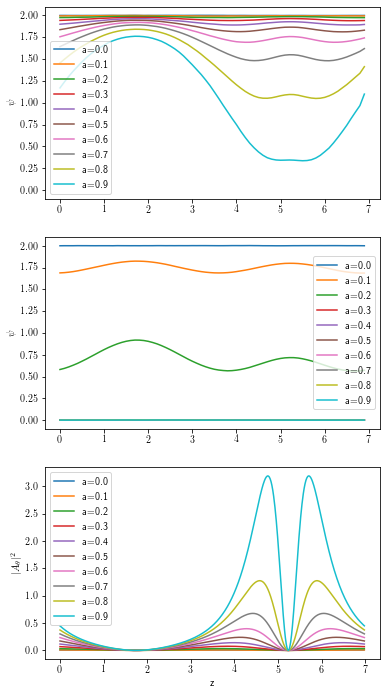

In [477]:
nrows, ncols = 3, 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(6,12))
zs = np.arange(0, 2*math.pi/k, z_space)
for a in a_s:
    axs[0].plot(zs,arrs_1[a], label="a="+str(round(a,3)))
axs[0].set_ylim((-.1,2.1))
axs[0].set_ylabel(r'$\psi$')
axs[0].legend()
for a in a_s:
    axs[1].plot(zs,arrs_2[a], label="a="+str(round(a,3)))
axs[1].set_ylim((-.1,2.1))
axs[1].set_ylabel(r'$\psi$')
axs[1].legend()
for a in a_s:
    cylinder = system_cylinder.Cylinder(wavenumber=k, radius=1, kappa=0)
    zs = np.arange(0, 2*math.pi/k, z_space/10)
    alpha_zs= [Ath2(alpha0, c0, n, a, z, cylinder) for z in zs]
    axs[2].plot(zs,alpha_zs, label="a="+str(round(a,3)))
axs[2].legend()
axs[2].set_ylabel(r'$|A_\theta|^2$')
axs[2].set_xlabel("z")
plt.savefig("k9_Ath2.png")